20221129

sarahfong

### intersect nullomers, empirical shuffle with phylop 100way bigWig

split by exonic/non-exonic


use bigWigAverageOverBed executable from UCSC to get phylop 


compare nullomers v. empirical background

In [31]:
import glob
from joblib import Parallel, delayed
import os
import pybedtools as pbt
import subprocess
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels as sm

%matplotlib inline

In [49]:
# append path
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_/")

# import config reader
import config_readwrite as crw
import count_lines as cl
import plot_params as pp

config_name = os.path.join(os.path.dirname(os.getcwd()), "config")

config, configname = crw.read_config(config_name)

In [3]:
# select config variables
ANNOT = "EXON"

# nullomer GENCODE intersections
OVERLAP = config[f"DATAx{ANNOT}"]["OVERLAP"]  
NOOVERLAP_REF = config[f"DATAx{ANNOT}"]["NOOVERLAP_REF"]

# nullomer shuffles
EX_EXP_SHUF = config["SHUFFLES"]["exon_exp_star"]
NOEX_EXP_SHUF = config["SHUFFLES"]["noexon_exp_star"]

# phylop files, wiggle track executables
PHYLOP_BW = config["PHYLOP"]["100WAY_BW"]
PHYLOP_PATH = config["PHYLOP"]["PATH"]
SRC_BWAVG = config["SRC"]["bigWigAverageOverBed"]

# functions

In [4]:
def getBigWigVal(test_bed, bw, outpath, src_bwavg):
    
    """
    write file.bed w/ wiggle track value average for coordinates in bed file
    
    input
        test_bed (str) - full path to bed file
        bw (str) - full path to bigwig file to parse
        outpath (str) - path to write outfile
        src_bwave (str) - path to bigWigAverageOverBed executable
    
    method
        1. string split the bed file id
        2. create out file
        3. check if path to bigWigAverageOverBed executable is provided. Else, provide
        4. build bigWigAverageOverBed command
        5. check that the output file does not already exist. 
            5a. if not, run command in commandline
        6. return the new outfile (str) to results
    
    return
        out (str) - full path to .bed file w/ wiggle value mean as 5th column.
        
    Note about bigWigAverageOverBed from kentutils:
    
        bigWigAverageOverBed v2 - Compute average score of big wig over each bed, which may have introns.
            
            usage:
               bigWigAverageOverBed in.bw in.bed out.tab -bedOut= <outfile>
    
    """
    
    #1
    id_name = (test_bed.split("/")[-1]).strip(".bed") # get the file id
    
    #2
    out = os.path.join(outpath, f"{id_name}-phylop100way.bed")  # out file str

    #3
    if src_bwavg is None:
        src_bwavg = "/wynton/home/ahituv/fongsl/nullomers/src/bigWigAverageOverBed"
    #4    
    cmd = f"{src_bwavg} {bw} {test_bed} {out}.tab -bedOut={out}"
    
    #5
    if os.path.exists(out) is False:
        os.system(cmd)
        print(cmd)
    #6    
    return out

In [5]:
def parallelBigWigVal(file_list, bw, outpath, src_bwavg):
    
    """
    run parallel jobs to parse bigwigs for mean values


    input
        file_list (list) - list of strs w/ full paths to bed files to run in parallel
        bw (str) - full path to bigwig file to parse
        outpath (str) - path to write outfile
        src_bwave (str) - path to bigWigAverageOverBed executable
        
    method
        1. run parallel jobs
        2. return list of outfiles
    
    notes
        ncores is fixed at 16
        
    """
    ncores=16
    
    exps_phylop = Parallel(
                        n_jobs=ncores, verbose=100, prefer="threads")\
                        (delayed(getBigWigVal)\
                        (e, bw,outpath, src_bwavg) for e in file_list)
    return exps_phylop
    

# Main

## exonic, non-exonic: extract bw values.  

In [6]:
# list of tuples of bed files and config names to intersect w/ phylop
testfiles = [(OVERLAP, "exon"), (NOOVERLAP_REF, "no-exon")] 

test_results = []  # list to collect results

for f, name in testfiles:
    
    phylop_results = getBigWigVal(f, PHYLOP_BW, PHYLOP_PATH, SRC_BWAVG)

    config["PHYLOP"][name]=phylop_results  # write output file to config
    
    test_results.append(phylop_results)  # append result file to list

## exonic, non-exonic shuffles; extract bw values

In [7]:
exp_lists = [
            glob.glob(EX_EXP_SHUF), 
            glob.glob(NOEX_EXP_SHUF)
            ]

exp_phylops =[] # list to collect results

for exp_list in exp_lists:
    
    # run parallel jobs to intersect bed w/ phylop
    exp_phylop = parallelBigWigVal(exp_list, PHYLOP_BW, PHYLOP_PATH, SRC_BWAVG) 
    
    exp_phylops.append(exp_phylop) # append list of outputs to collection list

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  15 tasks      | elaps

In [8]:
e_exp_phylops, ne_exp_phylops = exp_phylops

# Analyze 

## functions for analysis

In [11]:
def extract_phylop_values(bedfile):
    
    """
    return list of phylop average values from .bed file
    
    input
        bedfile (str) - path to bed file intersected w/ phylop.bw using bigWigAverageOverBed (above)
        
    method
        1. instantiate a list
        2. open the bedfile
        3. parse bedfile lines
        4. str split line to get relevant bedfile info, including phylop mean val at 4th index 
        5. append the value to a list of phylop values
    return
        phylop_vals (list) - list of mean phylop_values for all elements in the list. 
        
    """
    
    phylop_vals=[]  #1 collect phylop values from file
    
    #2 open the phylop.bed file
    with open(bedfile, "r") as phylofile:
        
        #3 parse lines
        for line in phylofile.readlines():
            
            #4 str split line to extract values
            chr_, posminusone, pos, nid, mean_phylop_val = (line.strip("\n")).split("\t")
            
            #5 append phylop_val to list of values
            phylop_vals.append(float(mean_phylop_val))
            
    return phylop_vals

In [59]:
def make_pdDataFrame(val_list, exp_val_list, sample_id):
    
    # make pd dataframe from val_list
    df=pd.DataFrame({"phylop":val_list})
    df["sample"] = sample_id
    
    # make pd dataframe from expected
    exp_df=pd.DataFrame({"phylop":exp_val_list})
    exp_df["sample"] = "shuffle"

    # concat the two dataframes together and reset index
    df=pd.concat([df, exp_df]).reset_index()
    
    return df

In [62]:
def results_stat_plot(df, sample_id):
    
    pp.fonts()
    
    # plot histplot
    fig,ax=plt.subplots(figsize=(6,6))
    sns.histplot(x="phylop", data=df, hue="sample", common_norm=False, stat="percent")
    ax.set(title=sample_id)
    
    # plot boxplot
    fig,ax=plt.subplots(figsize=(6,6))
    sns.boxplot(x="sample", y="phylop", data=df, notch=True, showfliers=False)
    ax.set(title=sample_id)

    # do MWU
    print(stats.mannwhitneyu(vals, exp_vals))

    # print descriptive stat
    print(df.groupby("sample")["phylop"].describe())

## run analysis 

4593 431478

 exon
MannwhitneyuResult(statistic=1108331347.5, pvalue=1.480447760350641e-43)
            count      mean       std     min    25%    50%    75%     max
sample                                                                    
exon       4593.0  1.669162  2.841767  -7.969 -0.092  0.605  2.851  10.003
shuffle  431478.0  1.083293  2.478348 -20.000 -0.198  0.303  1.498  10.003
24546 2454600

 nonexon
MannwhitneyuResult(statistic=30528603802.5, pvalue=0.00030053935936255773)
             count      mean       std     min      25%    50%    75%     max
sample                                                                       
nonexon    24546.0  0.089381  1.009987  -9.415 -0.32075  0.106  0.407   9.519
shuffle  2454600.0  0.046971  0.883650 -12.226 -0.32300  0.105  0.365  10.003


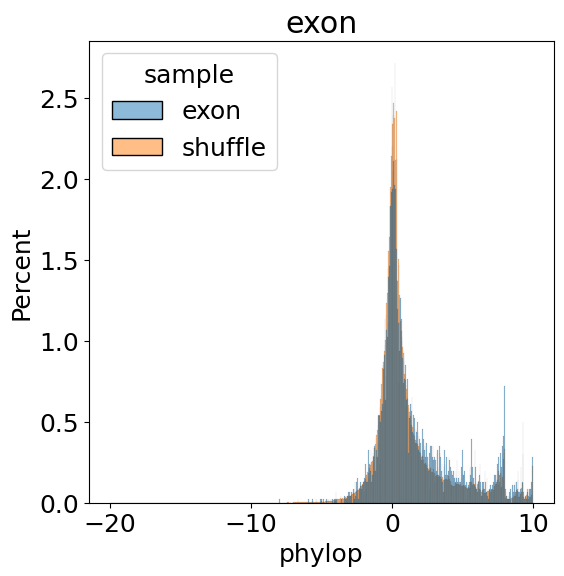

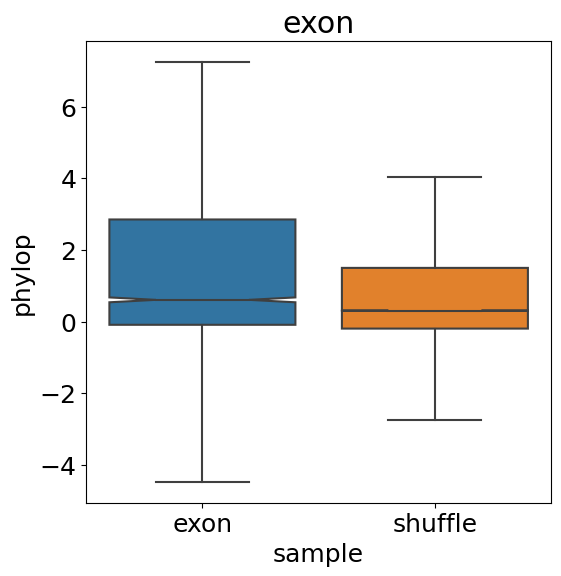

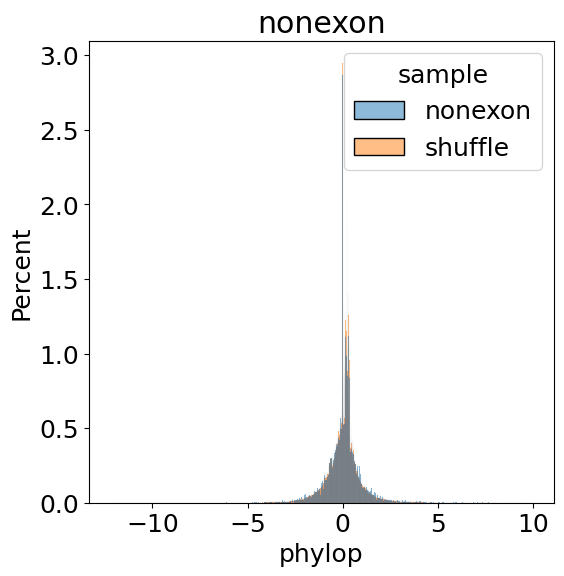

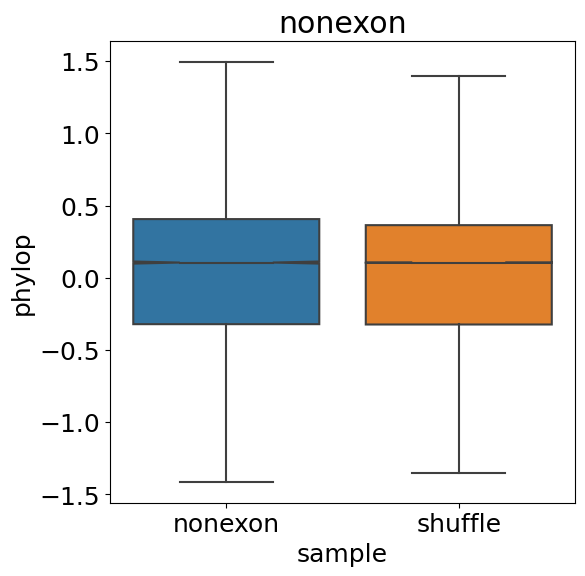

In [64]:
pairs = zip(test_results, exp_phylops)

for test, exp in pairs:


    vals = extract_phylop_values(test)

    exp_vals = []

    for e in exp:

        v = extract_phylop_values(e)
        exp_vals.extend(v)

    print(len(vals), len(exp_vals))
    
    if len(vals)==4593:
        sample_id="exon"
    else:
        sample_id="nonexon"
        
    print("\n", sample_id)
    
    df = make_pdDataFrame(vals, exp_vals, sample_id)
    
    # plot results
    results_stat_plot(df, sample_id)
    

# write config

In [9]:
crw.write_config(config, configname)